<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignments_Session9/blob/main/EVA6_Session_9_oneCyclePolicy_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-nj3qn670
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-nj3qn670
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98521 sha256=95d397cf6a9a6174ed843336de6fbf1114bc3b428444cad75d08dff3182793ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-i3ny_53d/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/gokul-pv/MyMainRepo

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Cloning into 'MyMainRepo'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 191 (delta 94), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (191/191), 54.90 KiB | 7.84 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [3]:
%matplotlib inline

print('importing...')
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch as AP
import random
import cv2

print('Done!')

importing...
Done!


**Viewing the applies transformations**

In [4]:
%cd MyMainRepo/

/content/MyMainRepo


In [5]:
import models
import main as m
import utils as ut


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Whole dataset ]
 - Numpy Shape: (60000, 32, 32, 3)
 - min: 0
 - max: 255
 - mean: 120.84449672851562
 - std: 64.13596441053241
 - var: 4113.421930869079
[Per Channel, standardised stats]
 - mean: [0.4919 0.4827 0.4472]
 - std: [0.247  0.2434 0.2616]
truck   cat  deer   cat


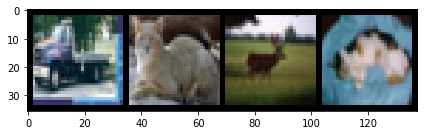

In [6]:
random.seed(42)
ut.data_stats()

In [8]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)

expample_transform = ut.AlbumentationTransforms([
                                                A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                                                A.RandomCrop(width=32, height=32,p=1),
                                                A.HorizontalFlip(p=1),
                                                A.CoarseDropout(max_holes=3,min_holes = 1, max_height=8, max_width=8, p=0.8,
                                                                fill_value=tuple([x * 255.0 for x in channel_means]),
                                                                min_height=8, min_width=8),
                                                A.Normalize(mean=channel_means, std=channel_stdevs,always_apply=True) 
                                                ])

Files already downloaded and verified


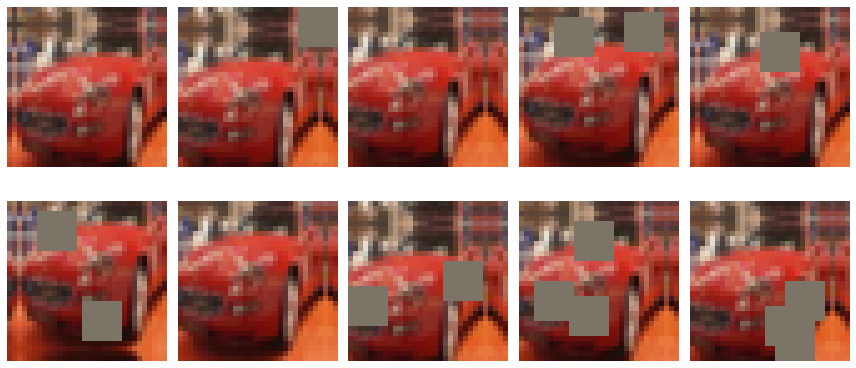

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
ut.visualize_augmentations(trainset,expample_transform,5 )

In [10]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)

train_transforms = ut.AlbumentationTransforms([
                                                A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                                                A.RandomCrop(width=32, height=32,p=1),
                                                A.HorizontalFlip(p=1),
                                                A.CoarseDropout(max_holes=3,min_holes = 1, max_height=8, max_width=8, p=0.8,
                                                                fill_value=tuple([x * 255.0 for x in channel_means]),
                                                                min_height=8, min_width=8),
                                                A.Normalize(mean=channel_means, std=channel_stdevs,always_apply=True)                                           
                                              ])
# Test Phase transformations
test_transforms = ut.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [11]:
batch_size = 512
classes, trainloader, testloader = m.load(train_transforms,test_transforms,batch_size)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. Define a Convolution Neural Network




In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet_custom().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-14            [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Cyclic Learning Rates

We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.
We'll plot loss vs learning rate plot.
We'll then select learning rate that is one power higher than the one where loss is minimum
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate
can be set to 1/3, 1/4th of max value.


In [13]:
pip install torch-lr-finder

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In [16]:
model = models.ResNet_custom().to(device)

In [17]:
from torch_lr_finder import LRFinder

def find_lr(model,train_loader, test_loader, start_lr, end_lr):    
  lr_epochs = 25
  num_iterations = len(test_loader) * lr_epochs

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.90, weight_decay=0.005)
  lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
  lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=end_lr, num_iter=num_iterations, step_mode="linear",diverge_th=50)
  
  # Plot
  max_lr = lr_finder.plot(suggest_lr=True,skip_start=0, skip_end=0)

  # Reset graph
  lr_finder.reset()
  return max_lr[1]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.70E-02


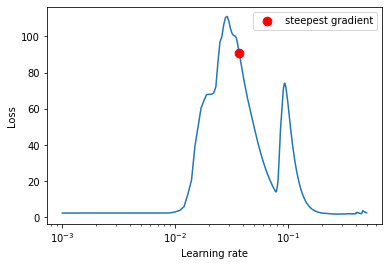

In [18]:
start_lr = 1e-3
end_lr = 0.5
lrmax= find_lr(model,trainloader, testloader, start_lr, end_lr)

In [19]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
learningRates = []
epochs=24
max_epoch = 5
lr = 0.01

## One Cycle Policy

In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during whole run with 2 steps of equal length. During first step, increase the learning rate from lower learning rate to higher learning rate. And in second step, decrease it from higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one addition to this. - During last few hundred/thousand iterations of cycle reduce the learning rate to 1/100th or 1/1000th of the lower learning rate.

Also, Author suggests that reducing momentum when learning rate is increasing. So, we make one cycle of momentum also with learning rate - Decrease momentum when learning rate is increasing and increase momentum when learning rate is decreasing.

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.9, weight_decay=0.005)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=lrmax,
                                  epochs=epochs, steps_per_epoch=len(trainloader),
                                  pct_start=5/epochs,div_factor=8)


In [21]:
for epoch in range(epochs):
  print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
  m.train(model, device, trainloader, optimizer, scheduler, criterion, epoch,train_losses,train_accuracy )
  m.test(model, device, criterion, testloader,test_losses, test_accuracy )
  for param_group in optimizer.param_groups:
    learningRates.append(param_group['lr']) 

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.004625000000000004


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.8406410217285156 Batch_id=97 Accuracy=25.19: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 3336/10000 (33.36%)

EPOCH: 2 LR: 0.007728773790896273


Loss=1.6792749166488647 Batch_id=97 Accuracy=41.93: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4858/10000 (48.58%)

EPOCH: 3 LR: 0.015849866685431622


Loss=1.2668534517288208 Batch_id=97 Accuracy=53.82: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5853/10000 (58.53%)

EPOCH: 4 LR: 0.025874019498494966


Loss=1.0496805906295776 Batch_id=97 Accuracy=62.16: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6586/10000 (65.86%)

EPOCH: 5 LR: 0.03395719173252646


Loss=0.7462247610092163 Batch_id=97 Accuracy=67.83: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6903/10000 (69.03%)

EPOCH: 6 LR: 0.03699997366843978


Loss=0.8030347228050232 Batch_id=97 Accuracy=73.15: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7671/10000 (76.71%)

EPOCH: 7 LR: 0.03674252379432511


Loss=0.7457497715950012 Batch_id=97 Accuracy=76.40: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7216/10000 (72.16%)

EPOCH: 8 LR: 0.035987471733708774


Loss=0.5342000722885132 Batch_id=97 Accuracy=79.01: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7811/10000 (78.11%)

EPOCH: 9 LR: 0.03475541333853058


Loss=0.5137326717376709 Batch_id=97 Accuracy=81.21: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8050/10000 (80.50%)

EPOCH: 10 LR: 0.03307995595007443


Loss=0.6042278409004211 Batch_id=97 Accuracy=82.94: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8345/10000 (83.45%)

EPOCH: 11 LR: 0.031006801678305992


Loss=0.4161522686481476 Batch_id=97 Accuracy=84.37: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8014/10000 (80.14%)

EPOCH: 12 LR: 0.028592500767449246


Loss=0.33311039209365845 Batch_id=97 Accuracy=85.94: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8355/10000 (83.55%)

EPOCH: 13 LR: 0.02590290905273962


Loss=0.3559514880180359 Batch_id=97 Accuracy=87.13: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8464/10000 (84.64%)

EPOCH: 14 LR: 0.023011391584912055


Loss=0.2968670129776001 Batch_id=97 Accuracy=88.40: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8460/10000 (84.60%)

EPOCH: 15 LR: 0.019996821422865418


Loss=0.3034551441669464 Batch_id=97 Accuracy=89.55: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8326/10000 (83.26%)

EPOCH: 16 LR: 0.01694142818222242


Loss=0.30147919058799744 Batch_id=97 Accuracy=90.67: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8674/10000 (86.74%)

EPOCH: 17 LR: 0.013928555025772072


Loss=0.24996702373027802 Batch_id=97 Accuracy=91.46: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8745/10000 (87.45%)

EPOCH: 18 LR: 0.011040385279248183


Loss=0.1894773244857788 Batch_id=97 Accuracy=92.83: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8739/10000 (87.39%)

EPOCH: 19 LR: 0.00835570068443931


Loss=0.19520695507526398 Batch_id=97 Accuracy=93.83: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8945/10000 (89.45%)

EPOCH: 20 LR: 0.005947732438641431


Loss=0.1330786794424057 Batch_id=97 Accuracy=95.19: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9019/10000 (90.19%)

EPOCH: 21 LR: 0.003882163638495154


Loss=0.13035117089748383 Batch_id=97 Accuracy=96.23: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9063/10000 (90.63%)

EPOCH: 22 LR: 0.0022153376163324963


Loss=0.1017017588019371 Batch_id=97 Accuracy=97.10: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9153/10000 (91.53%)

EPOCH: 23 LR: 0.0009927210409468928


Loss=0.09915637969970703 Batch_id=97 Accuracy=97.76: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9181/10000 (91.81%)

EPOCH: 24 LR: 0.0002476637053913235


Loss=0.07570220530033112 Batch_id=97 Accuracy=97.97: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.0005, Accuracy: 9188/10000 (91.88%)



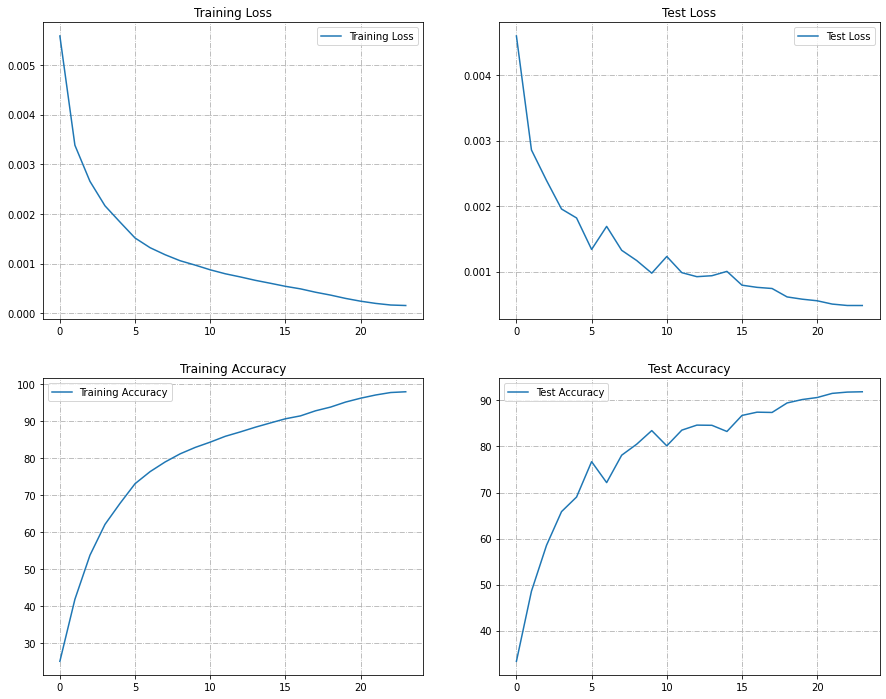

In [23]:
ut.plot_loss_accurracy(train_losses,train_accuracy, test_losses,  test_accuracy)

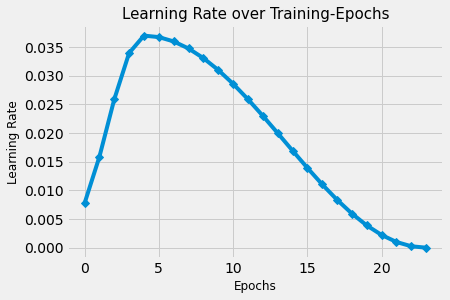

In [22]:
with plt.style.context('fivethirtyeight'):
  plt.plot(learningRates, '-D')
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Learning Rate', fontsize=12)
  plt.title('Learning Rate over Training-Epochs',fontsize=15)

Plotting the misclassified image

In [24]:
misclassified_images = []
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

ut.evaluate_accuracy(model,device,testloader,misclassified_images,classes, correct_pred, total_pred )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


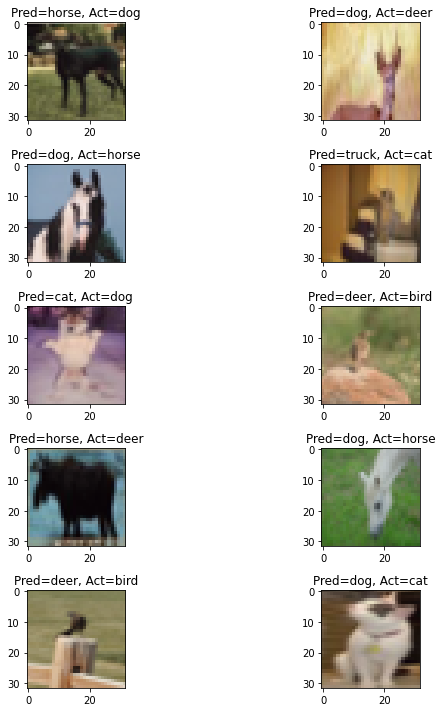

Accuracy for class plane is: 93.4 %
Accuracy for class car   is: 96.7 %
Accuracy for class bird  is: 88.6 %
Accuracy for class cat   is: 83.0 %
Accuracy for class deer  is: 92.5 %
Accuracy for class dog   is: 86.2 %
Accuracy for class frog  is: 95.1 %
Accuracy for class horse is: 93.8 %
Accuracy for class ship  is: 95.5 %
Accuracy for class truck is: 94.0 %


In [25]:
ut.show_misclassified_images(misclassified_images,classes, correct_pred, total_pred )